<a href="https://colab.research.google.com/github/grace-arina/Diagnosing-Pneumonia_CNN/blob/Olgert/Olgert_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
#Importin
import pandas as pd
import numpy as np
np.random.seed(123)
import datetime

import scipy
import os, shutil
from PIL import Image
from scipy import ndimage


import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, SeparableConv2D , BatchNormalization,Dropout
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from keras.callbacks import EarlyStopping, ModelCheckpoint, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')


import warnings
warnings.filterwarnings('ignore')

%load_ext tensorboard

In [2]:
image_size = (150,150)
batch_size = 50

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/chest_xray/train",
    image_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale")

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/chest_xray/test",
    image_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale")

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/chest_xray/val",
    image_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale")


Found 5022 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 210 files belonging to 2 classes.


In [3]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [5]:
for image_batch, labels_batch in train_ds.take(1):
  print(image_batch.shape)
  print(f"Labels for train ds: {labels_batch}")
  break

(50, 150, 150, 1)
Labels for train ds: [1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0
 1 1 0 1 1 1 1 0 1 1 1 1 0]


In [6]:
for image_batch, labels_batch in train_ds.take(2):
  print(image_batch.shape)
  print(f"Labels for train ds: {labels_batch}")
  break

(50, 150, 150, 1)
Labels for train ds: [1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0
 1 1 1 0 1 1 1 1 0 1 1 1 0]


In [7]:
#Pulls labels from test_ds
test_labels= np.concatenate([y for x, y in test_ds], axis=0)

In [8]:
tpain = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=tpain)
val_ds = val_ds.prefetch(buffer_size=tpain)

In [97]:
#Creatiung function to evaluate model
def model_eval(model):#input current model, train data and test data
  results_train = model.evaluate(train_ds) #evaluates train input
  results_test = model.evaluate(test_ds) #evaluates test input
  # pred = model.predict(test_ds)
  # preds = np.where(pred>0.5, 1,0)
  # cm  = confusion_matrix(test_labels, preds, normalize="true")
  return print(f'Train Loss: {results_train[0]}, Train Accuracy: {results_train[1]} \n Test Loss: {results_test[0]}, Test Accuracy: {results_test[1]}.')

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.RandomRotation(0.4)(inputs)
    x = layers.RandomZoom(0.2)(x)


    x = layers.Rescaling(1./255)(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)

    x = layers.SeparableConv2D(256, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)            
    x = layers.SeparableConv2D(512,3, padding="same")(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)    
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x) 
    x = Dense(64, activation='relu')(x)   
    previous_block_activation = x  # Set aside residual

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model0 = make_model(input_shape=image_size + (1,), num_classes=2)
keras.utils.plot_model(model0, show_shapes=True)

In [ ]:
model0.summary()

In [93]:
early_stop = EarlyStopping(monitor= "val_loss", mode="min", patience = 10, restore_best_weights=True)
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/my_model0.h5",monitor= "val_loss", save_best_only=True )
lr_rate = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=.000000001)
log_dir = "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/logs fit/model0" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, mod_checkpt, lr_rate, tensorboard_callback]

In [ ]:
model0.compile(optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])

result_0 = model0.fit(train_ds, epochs=500, batch_size=50, validation_data=val_ds, shuffle=True, callbacks=callbacks)

In [ ]:
model_eval(model0, train_ds, test_ds)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.RandomRotation(0.6)(x)
    x = layers.RandomZoom(0.3)(x)


    x = layers.Rescaling(1./255)(inputs)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)

    x = layers.SeparableConv2D(256, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)            
    x = layers.SeparableConv2D(512,3, padding="same")(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    previous_block_activation = x  # Set aside residual
    for size in [128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = Flatten()(x)   
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x) 
    x = Dense(64, activation='relu')(x)   

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model1 = make_model(input_shape=(image_size) + (1,), num_classes=2)
keras.utils.plot_model(model1, show_shapes=True)

In [ ]:
model1.summary()

In [ ]:
early_stop = EarlyStopping(monitor= "val_loss", mode="min", patience = 10, restore_best_weights=True)
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/my_model1.h5",monitor= "val_loss", save_best_only=True )
lr_rate = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=.000000001)
log_dir = "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/logs fit/model1" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, mod_checkpt, lr_rate, tensorboard_callback]

In [ ]:
model1.compile(optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])

result1 = model1.fit(train_ds, epochs=500, batch_size=50, validation_data=val_ds, shuffle=True, callbacks=callbacks)

In [ ]:
model1_eval = model_eval(model1)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.6)(x)
    x = layers.RandomZoom(0.3)(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)

    x = layers.SeparableConv2D(256, 3, padding="same", activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(256, 3, padding="same",activation='relu')(x)
    x = layers.BatchNormalization()(x)    
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(512, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool5')(x)    


    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)   

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model2 = make_model(input_shape=(image_size) + (1,), num_classes=2)
keras.utils.plot_model(model2, show_shapes=True)

In [ ]:
model2.summary()

In [ ]:
early_stop = EarlyStopping(monitor= "val_loss", mode="min", patience = 10, restore_best_weights=True)
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/my_model2.h5",monitor= "val_loss", save_best_only=True )
lr_rate = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=.000000001)
log_dir = "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/logs fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, mod_checkpt, lr_rate, tensorboard_callback]

In [ ]:
model2.compile(optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])

result2 = model2.fit(train_ds, epochs=500, batch_size=50, validation_data=val_ds, shuffle=True, callbacks=callbacks)

In [ ]:
model2_eval = model_eval(model2)

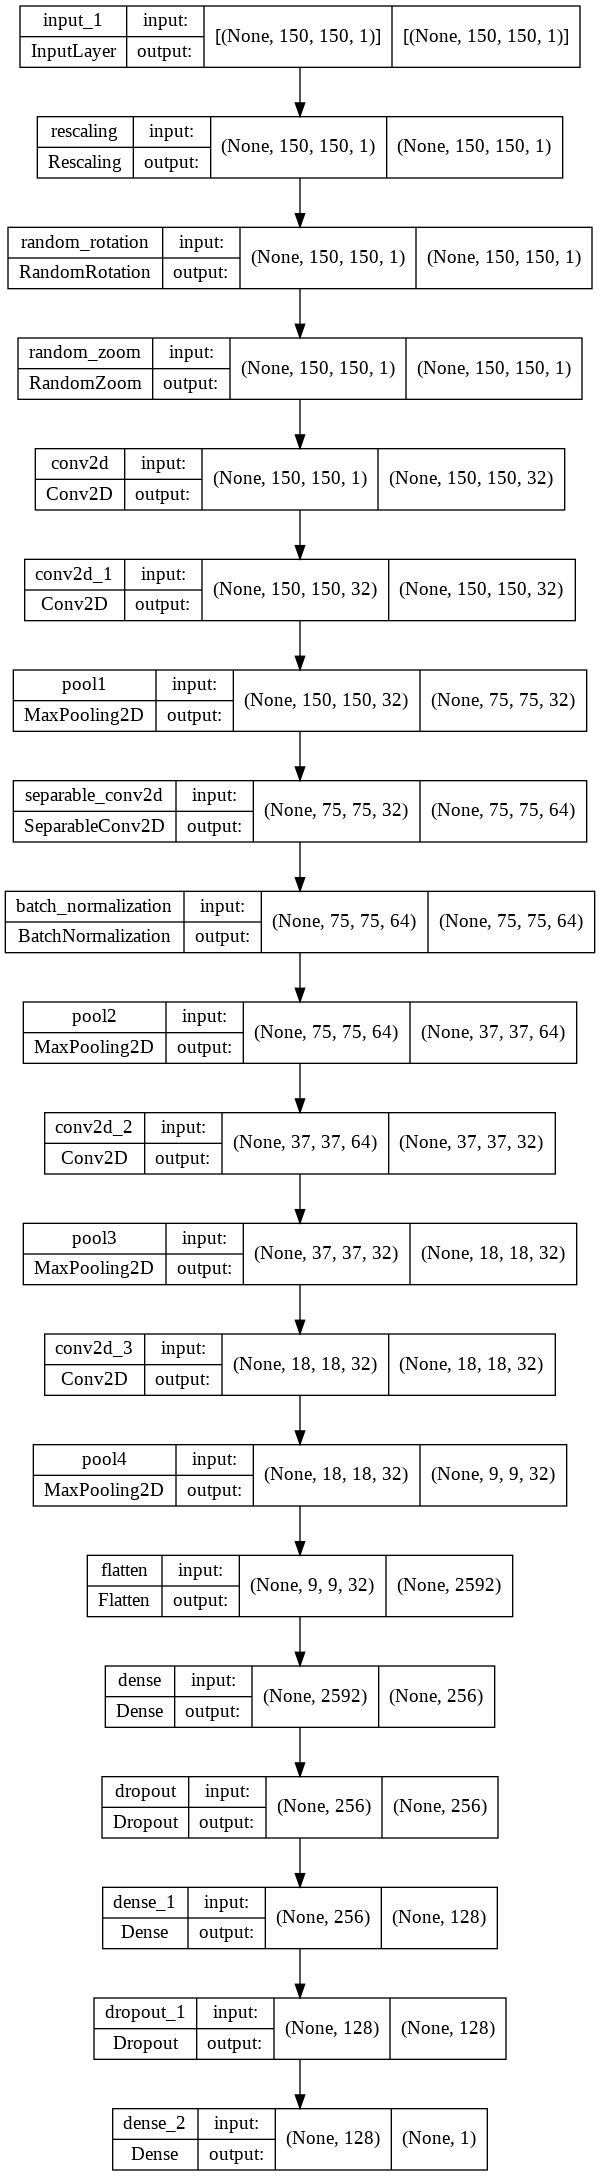

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.6)(x)
    x = layers.RandomZoom(0.2)(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = layers.SeparableConv2D(64, 3, padding="same", activation='relu')(x)
    x = layers.BatchNormalization()(x) 
    x = MaxPooling2D((2,2), name='pool2')(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)    
    x = Dense(128, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model3 = make_model(input_shape=(image_size) + (1,), num_classes=2)
keras.utils.plot_model(model3, show_shapes=True)

In [11]:
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 1)       0         
                                                                 
 random_rotation (RandomRota  (None, 150, 150, 1)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 150, 150, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                             

In [12]:
early_stop = EarlyStopping(monitor= "val_loss", mode="min", patience = 10, restore_best_weights=True)
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/my_model3.h5",monitor= "val_loss", save_best_only=True )
lr_rate = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=.000000001)
log_dir = "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/logs fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, mod_checkpt, lr_rate, tensorboard_callback]

In [13]:
model3.compile(optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])

result3 = model3.fit(train_ds, epochs=500, batch_size=50, validation_data=val_ds, shuffle=True, callbacks=callbacks)

Epoch 1/500
101/101 [==============================] - 66s 634ms/step - loss: 0.4423 - accuracy: 0.7913 - recall: 0.9330 - val_loss: 0.5512 - val_accuracy: 0.7238 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/500
101/101 [==============================] - 67s 663ms/step - loss: 0.2583 - accuracy: 0.8901 - recall: 0.9223 - val_loss: 0.5063 - val_accuracy: 0.7238 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/500
101/101 [==============================] - 65s 639ms/step - loss: 0.2341 - accuracy: 0.9042 - recall: 0.9333 - val_loss: 0.6102 - val_accuracy: 0.7238 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/500
101/101 [==============================] - 64s 628ms/step - loss: 0.2023 - accuracy: 0.9223 - recall: 0.9459 - val_loss: 0.5296 - val_accuracy: 0.7238 - val_recall: 1.0000 - lr: 0.0010
Epoch 5/500
101/101 [==============================] - 66s 653ms/step - loss: 0.2199 - accuracy: 0.9156 - recall: 0.9418 - val_loss: 0.5046 - val_accuracy: 0.7238 - val_recall: 1.0000 - lr: 0.0010
Epoch 6/500
101

In [98]:
model3_eval = model_eval(model3)

13/13 [==============================] - 2s 126ms/step - loss: 0.3422 - accuracy: 0.8638 - recall: 0.9692
Train Loss: 0.13839273154735565, Train Accuracy: 0.9514137506484985 
 Test Loss: 0.3422026038169861, Test Accuracy: 0.8637820482254028.


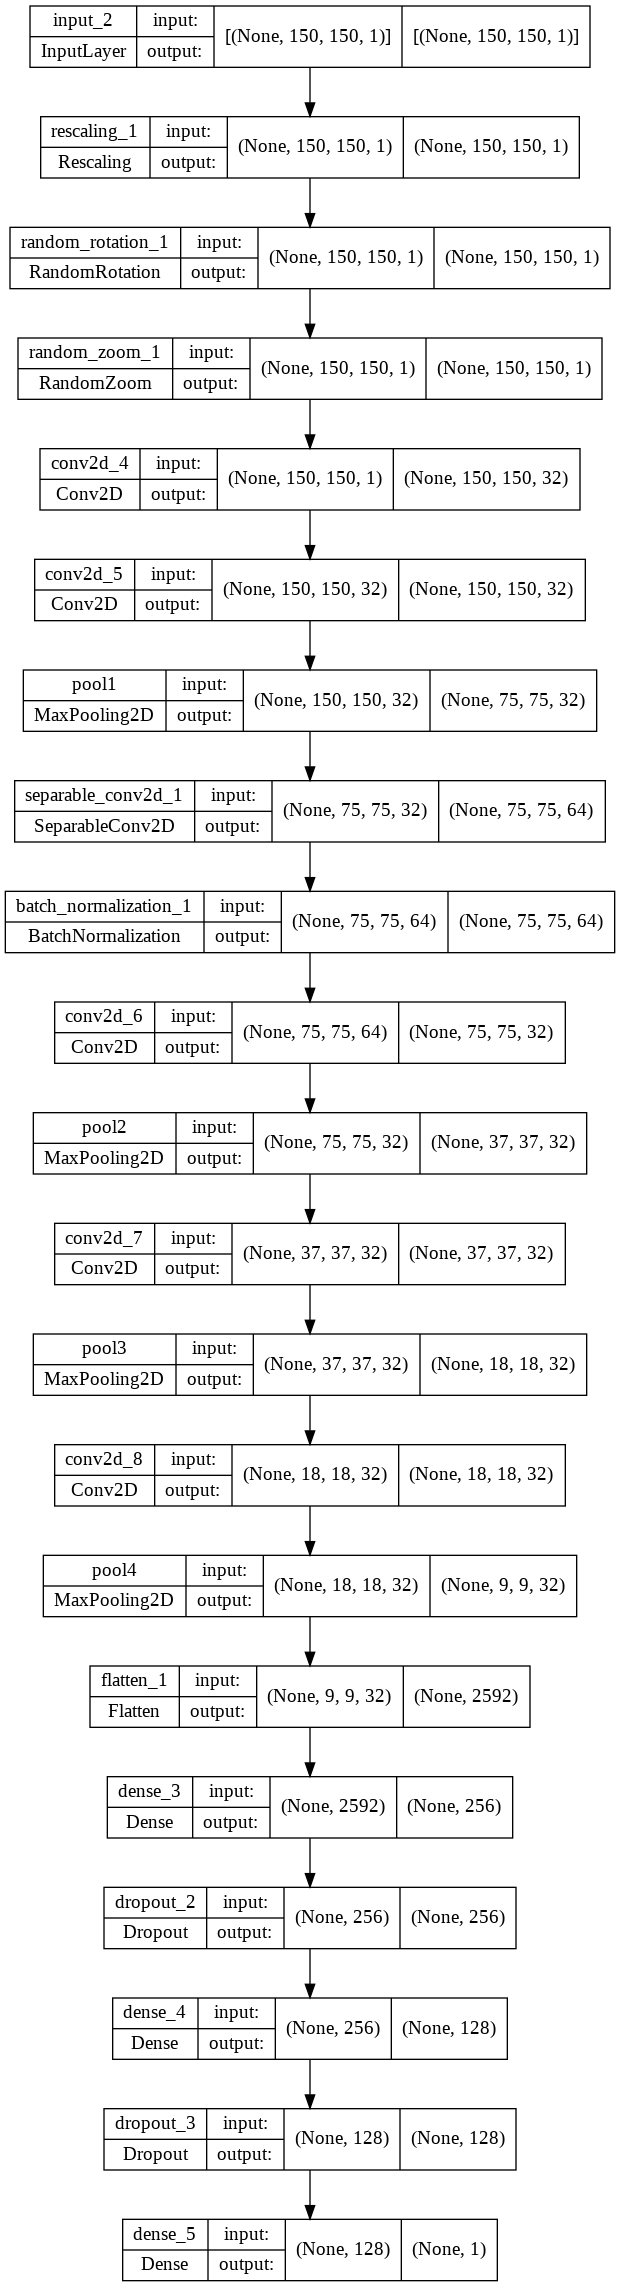

In [15]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.6)(x)
    x = layers.RandomZoom(0.2)(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = layers.SeparableConv2D(64, 3, padding="same", activation='relu')(x)
    x = layers.BatchNormalization()(x) 
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)    
    x = Dense(128, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model4 = make_model(input_shape=(image_size) + (1,), num_classes=2)
keras.utils.plot_model(model4, show_shapes=True)

In [16]:
model4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 1)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 150, 150, 1)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 150, 150, 1)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      9248      
                                                           

In [17]:
early_stop = EarlyStopping(monitor= "val_loss", mode="min", patience = 10, restore_best_weights=True)
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/my_model4.h5",monitor= "val_loss", save_best_only=True )
lr_rate = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=.000000001)
log_dir = "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/logs fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, mod_checkpt, lr_rate, tensorboard_callback]

In [18]:
model4.compile(optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])

result4 = model4.fit(train_ds, epochs=500, batch_size=50, validation_data=val_ds, shuffle=True, callbacks=callbacks)

Epoch 1/500
101/101 [==============================] - 86s 832ms/step - loss: 0.4403 - accuracy: 0.7947 - recall_1: 0.9429 - val_loss: 0.6032 - val_accuracy: 0.8333 - val_recall_1: 0.8553 - lr: 0.0010
Epoch 2/500
101/101 [==============================] - 88s 868ms/step - loss: 0.2882 - accuracy: 0.8813 - recall_1: 0.9164 - val_loss: 0.5311 - val_accuracy: 0.8952 - val_recall_1: 0.9868 - lr: 0.0010
Epoch 3/500
101/101 [==============================] - 87s 855ms/step - loss: 0.2655 - accuracy: 0.8959 - recall_1: 0.9349 - val_loss: 0.4348 - val_accuracy: 0.7762 - val_recall_1: 1.0000 - lr: 0.0010
Epoch 4/500
101/101 [==============================] - 86s 849ms/step - loss: 0.2224 - accuracy: 0.9170 - recall_1: 0.9408 - val_loss: 0.3774 - val_accuracy: 0.8762 - val_recall_1: 0.9868 - lr: 0.0010
Epoch 5/500
101/101 [==============================] - 87s 855ms/step - loss: 0.1991 - accuracy: 0.9273 - recall_1: 0.9475 - val_loss: 0.3969 - val_accuracy: 0.7476 - val_recall_1: 1.0000 - lr: 0.

In [99]:
model4_eval = model_eval(model4)

13/13 [==============================] - 3s 182ms/step - loss: 0.3002 - accuracy: 0.8814 - recall_1: 0.9410
Train Loss: 0.18700425326824188, Train Accuracy: 0.9350855946540833 
 Test Loss: 0.3002481162548065, Test Accuracy: 0.8814102411270142.


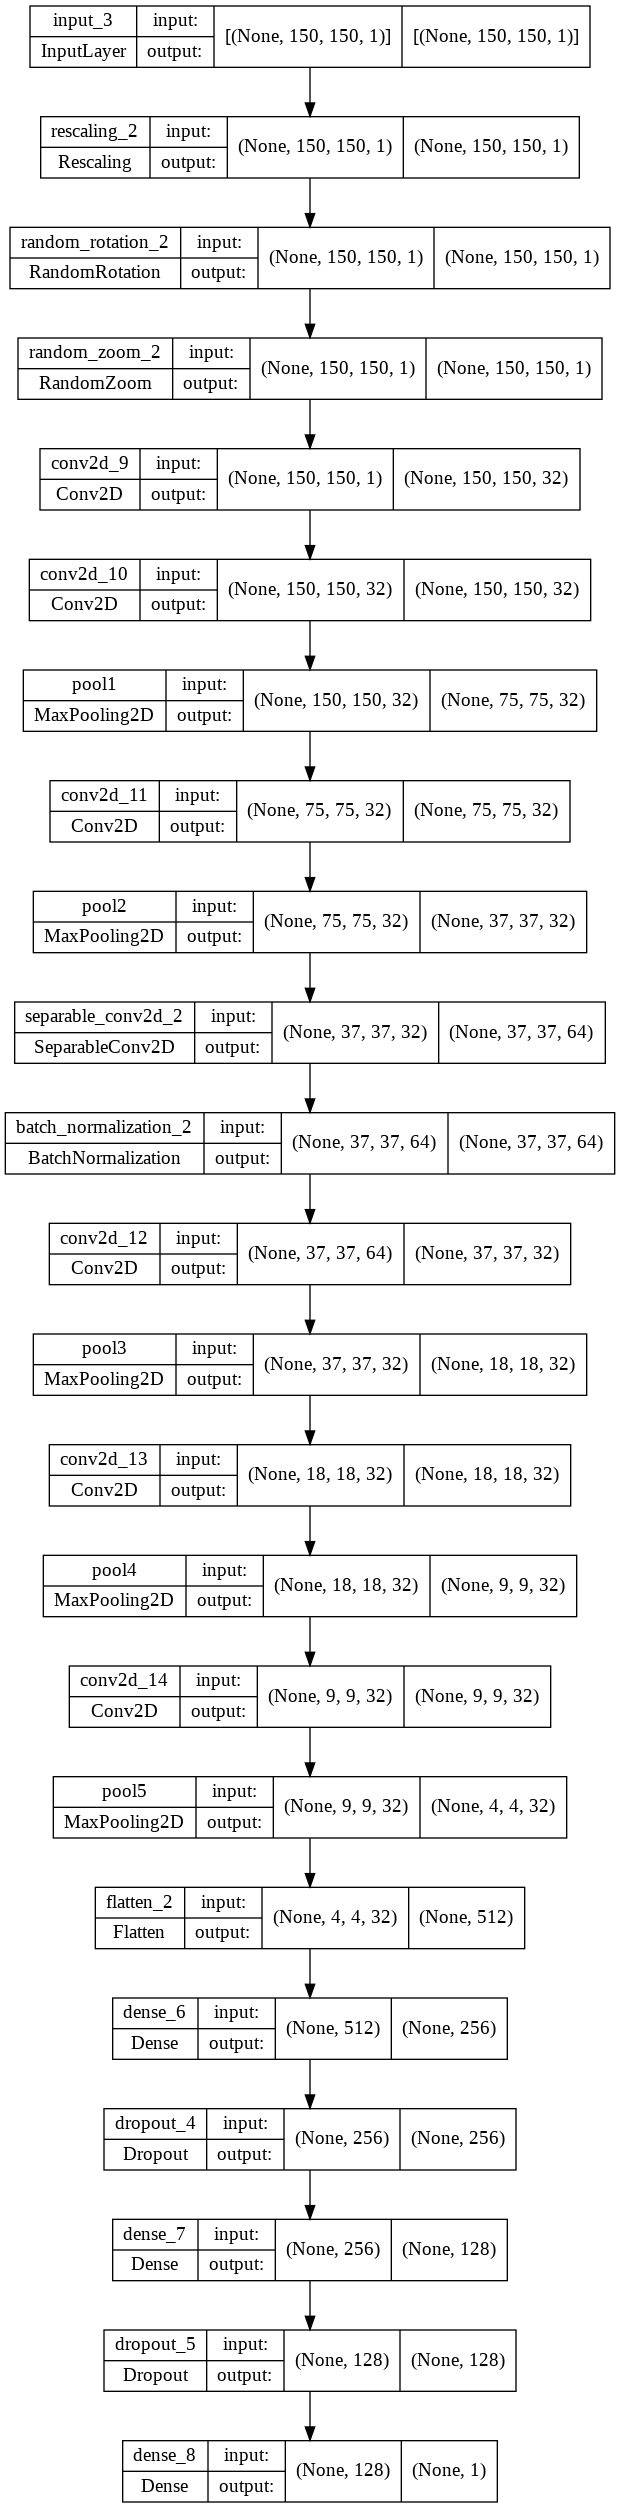

In [20]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.6)(x)
    x = layers.RandomZoom(0.2)(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool2')(x)    

    x = layers.SeparableConv2D(64, 3, padding="same", activation='relu')(x)
    x = layers.BatchNormalization()(x) 
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool5')(x)

    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)    
    x = Dense(128, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model5 = make_model(input_shape=(image_size) + (1,), num_classes=2)
keras.utils.plot_model(model5, show_shapes=True)

In [21]:
model5.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 1)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 150, 150, 1)      0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 150, 150, 1)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 conv2d_10 (Conv2D)          (None, 150, 150, 32)      9248      
                                                           

In [22]:
early_stop = EarlyStopping(monitor= "val_loss", mode="min", patience = 10, restore_best_weights=True)
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/my_model5.h5",monitor= "val_loss", save_best_only=True )
lr_rate = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=.000000001)
log_dir = "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/logs fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, mod_checkpt, lr_rate, tensorboard_callback]

In [23]:
model5.compile(optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])

result5 = model5.fit(train_ds, epochs=500, batch_size=50, validation_data=val_ds, shuffle=True, callbacks=callbacks)

Epoch 1/500
101/101 [==============================] - 80s 770ms/step - loss: 0.4654 - accuracy: 0.7714 - recall_2: 0.9426 - val_loss: 0.5374 - val_accuracy: 0.7238 - val_recall_2: 1.0000 - lr: 0.0010
Epoch 2/500
101/101 [==============================] - 78s 767ms/step - loss: 0.3073 - accuracy: 0.8714 - recall_2: 0.9252 - val_loss: 0.6849 - val_accuracy: 0.7238 - val_recall_2: 1.0000 - lr: 0.0010
Epoch 3/500
101/101 [==============================] - 78s 764ms/step - loss: 0.2606 - accuracy: 0.8903 - recall_2: 0.9292 - val_loss: 0.3682 - val_accuracy: 0.8476 - val_recall_2: 0.9868 - lr: 0.0010
Epoch 4/500
101/101 [==============================] - 77s 756ms/step - loss: 0.2401 - accuracy: 0.9014 - recall_2: 0.9298 - val_loss: 0.3879 - val_accuracy: 0.7571 - val_recall_2: 0.9934 - lr: 0.0010
Epoch 5/500
101/101 [==============================] - 78s 766ms/step - loss: 0.2155 - accuracy: 0.9160 - recall_2: 0.9429 - val_loss: 0.3587 - val_accuracy: 0.8810 - val_recall_2: 0.8750 - lr: 0.

In [100]:
model5_eval = model_eval(model5)

13/13 [==============================] - 2s 127ms/step - loss: 0.3751 - accuracy: 0.8622 - recall_2: 0.9744
Train Loss: 0.1284487098455429, Train Accuracy: 0.9512146711349487 
 Test Loss: 0.3751220107078552, Test Accuracy: 0.8621794581413269.


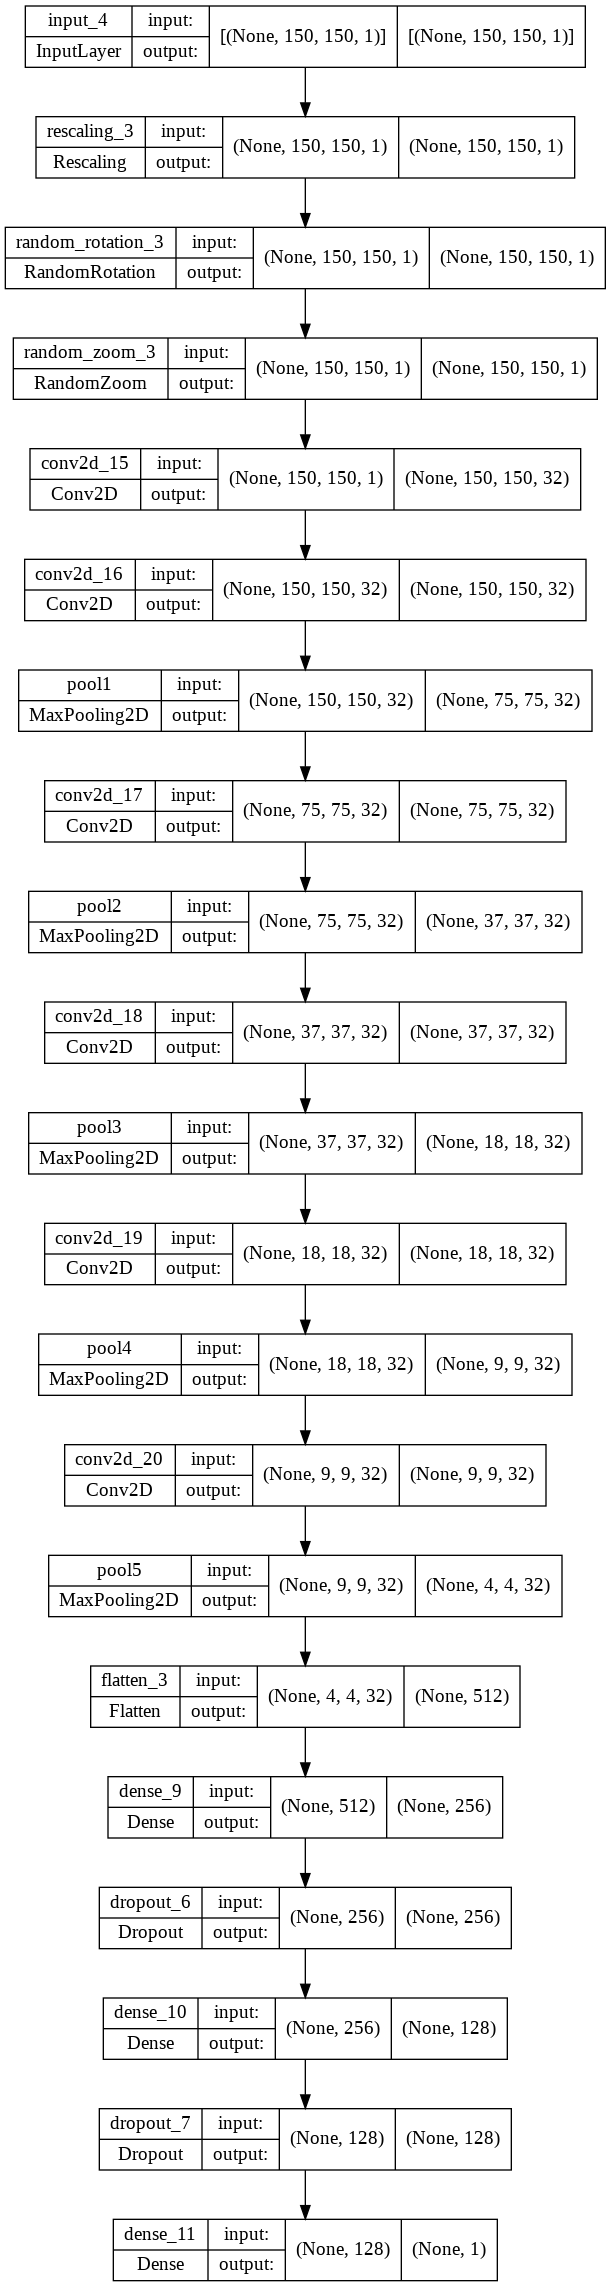

In [25]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.6)(x)
    x = layers.RandomZoom(0.2)(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool2')(x)    

    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool5')(x)

    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)    
    x = Dense(128, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model6 = make_model(input_shape=(image_size) + (1,), num_classes=2)
keras.utils.plot_model(model6, show_shapes=True)

In [26]:
model6.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 150, 150, 1)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 150, 150, 1)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 150, 150, 1)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 conv2d_16 (Conv2D)          (None, 150, 150, 32)      9248      
                                                           

In [27]:
early_stop = EarlyStopping(monitor= "val_loss", mode="min", patience = 10, restore_best_weights=True)
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/my_model6.h5",monitor= "val_loss", save_best_only=True )
lr_rate = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=.000000001)
log_dir = "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/logs fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, mod_checkpt, lr_rate, tensorboard_callback]

In [28]:
model6.compile(optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])

result_6 = model6.fit(train_ds, epochs=500, batch_size=50, validation_data=val_ds, shuffle=True, callbacks=callbacks)

Epoch 1/500
101/101 [==============================] - 65s 623ms/step - loss: 0.5888 - accuracy: 0.7403 - recall_3: 0.9920 - val_loss: 0.5990 - val_accuracy: 0.7238 - val_recall_3: 1.0000 - lr: 0.0010
Epoch 2/500
101/101 [==============================] - 68s 670ms/step - loss: 0.5461 - accuracy: 0.7443 - recall_3: 0.9987 - val_loss: 0.3978 - val_accuracy: 0.7571 - val_recall_3: 1.0000 - lr: 0.0010
Epoch 3/500
101/101 [==============================] - 70s 692ms/step - loss: 0.3923 - accuracy: 0.8027 - recall_3: 0.8979 - val_loss: 0.2779 - val_accuracy: 0.9143 - val_recall_3: 0.9605 - lr: 0.0010
Epoch 4/500
101/101 [==============================] - 70s 684ms/step - loss: 0.3444 - accuracy: 0.8413 - recall_3: 0.9049 - val_loss: 0.2252 - val_accuracy: 0.9143 - val_recall_3: 0.9539 - lr: 0.0010
Epoch 5/500
101/101 [==============================] - 69s 678ms/step - loss: 0.3069 - accuracy: 0.8684 - recall_3: 0.9161 - val_loss: 0.2362 - val_accuracy: 0.8810 - val_recall_3: 0.9539 - lr: 0.

In [101]:
model6_eval = model_eval(model6)

13/13 [==============================] - 2s 115ms/step - loss: 0.2870 - accuracy: 0.8798 - recall_3: 0.9667
Train Loss: 0.16710256040096283, Train Accuracy: 0.9289127588272095 
 Test Loss: 0.2870437204837799, Test Accuracy: 0.879807710647583.


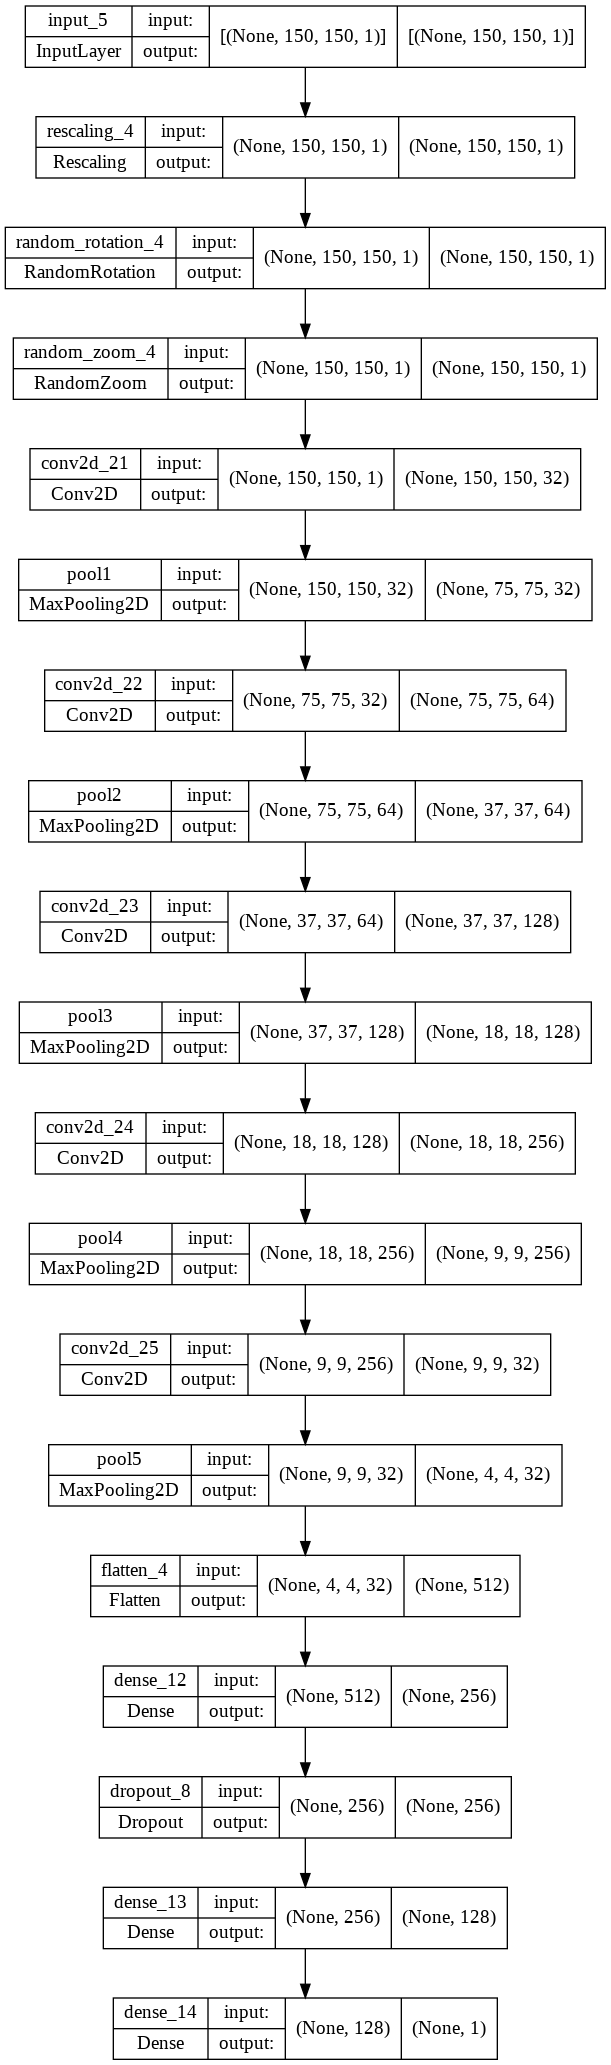

In [30]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.6)(x)
    x = layers.RandomZoom(0.2)(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool2')(x)    

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)

    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool5')(x)    

    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)    
    x = Dense(128, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model7 = make_model(input_shape=(image_size) + (1,), num_classes=2)
keras.utils.plot_model(model7, show_shapes=True)

In [31]:
model7.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 150, 150, 1)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 150, 150, 1)      0         
 tation)                                                         
                                                                 
 random_zoom_4 (RandomZoom)  (None, 150, 150, 1)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 75, 75, 32)        0         
                                                           

In [32]:
early_stop = EarlyStopping(monitor= "val_loss", mode="min", patience = 10, restore_best_weights=True)
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/model7.h5",monitor= "val_loss", save_best_only=True )
lr_rate = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=.000000001)
log_dir = "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/logs fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, mod_checkpt, lr_rate, tensorboard_callback]

In [33]:
model7.compile(optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])

result_7 = model7.fit(train_ds, epochs=500, batch_size=50, validation_data=val_ds, shuffle=True, callbacks=callbacks)

Epoch 1/500
101/101 [==============================] - 47s 448ms/step - loss: 0.5535 - accuracy: 0.7417 - recall_4: 0.9853 - val_loss: 0.3650 - val_accuracy: 0.8476 - val_recall_4: 0.9737 - lr: 0.0010
Epoch 2/500
101/101 [==============================] - 39s 382ms/step - loss: 0.4092 - accuracy: 0.7981 - recall_4: 0.9075 - val_loss: 0.4302 - val_accuracy: 0.7857 - val_recall_4: 0.7105 - lr: 0.0010
Epoch 3/500
101/101 [==============================] - 43s 418ms/step - loss: 0.3250 - accuracy: 0.8528 - recall_4: 0.9075 - val_loss: 0.2821 - val_accuracy: 0.8762 - val_recall_4: 0.8750 - lr: 0.0010
Epoch 4/500
101/101 [==============================] - 36s 350ms/step - loss: 0.2710 - accuracy: 0.8865 - recall_4: 0.9220 - val_loss: 0.2468 - val_accuracy: 0.9000 - val_recall_4: 0.9145 - lr: 0.0010
Epoch 5/500
101/101 [==============================] - 36s 349ms/step - loss: 0.2549 - accuracy: 0.8935 - recall_4: 0.9268 - val_loss: 0.2639 - val_accuracy: 0.8905 - val_recall_4: 0.8684 - lr: 0.

In [102]:
model7_eval = model_eval(model7)

13/13 [==============================] - 1s 61ms/step - loss: 0.3458 - accuracy: 0.8750 - recall_4: 0.9744
Train Loss: 0.13362061977386475, Train Accuracy: 0.9456391930580139 
 Test Loss: 0.3457574248313904, Test Accuracy: 0.875.


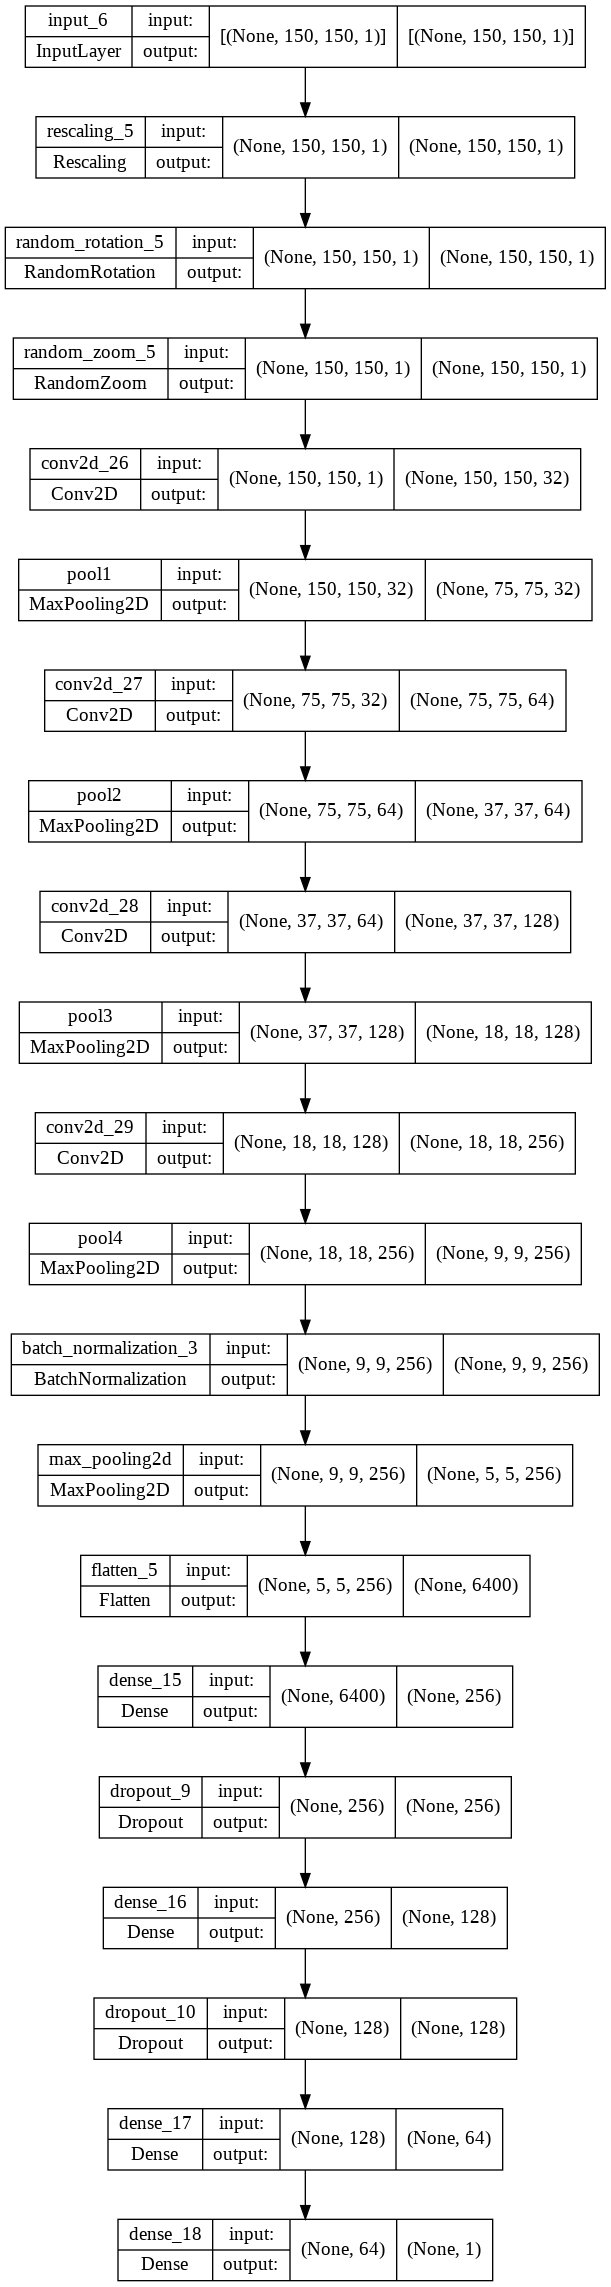

In [35]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.6)(x)
    x = layers.RandomZoom(0.2)(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool2')(x)    

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)

    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)      
    x = Dense(64, activation='relu')(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model8 = make_model(input_shape=(image_size) + (1,), num_classes=2)
keras.utils.plot_model(model8, show_shapes=True)


In [36]:
model8.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 rescaling_5 (Rescaling)     (None, 150, 150, 1)       0         
                                                                 
 random_rotation_5 (RandomRo  (None, 150, 150, 1)      0         
 tation)                                                         
                                                                 
 random_zoom_5 (RandomZoom)  (None, 150, 150, 1)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 75, 75, 32)        0         
                                                           

In [37]:
early_stop = EarlyStopping(monitor= "val_loss", mode="min", patience = 10, restore_best_weights=True)
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/my_model8.h5",monitor= "val_loss", save_best_only=True )
lr_rate = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=.000000001)
log_dir = "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/logs fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, mod_checkpt, lr_rate, tensorboard_callback]

In [38]:
model8.compile(optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])

result_8 = model8.fit(train_ds, epochs=500, batch_size=50, validation_data=val_ds, shuffle=True, callbacks=callbacks)

Epoch 1/500
101/101 [==============================] - 46s 436ms/step - loss: 0.3703 - accuracy: 0.8164 - recall_5: 0.8850 - val_loss: 0.5131 - val_accuracy: 0.7238 - val_recall_5: 1.0000 - lr: 0.0010
Epoch 2/500
101/101 [==============================] - 43s 422ms/step - loss: 0.2884 - accuracy: 0.8765 - recall_5: 0.9137 - val_loss: 0.5653 - val_accuracy: 0.7238 - val_recall_5: 1.0000 - lr: 0.0010
Epoch 3/500
101/101 [==============================] - 43s 423ms/step - loss: 0.2493 - accuracy: 0.8949 - recall_5: 0.9236 - val_loss: 0.4814 - val_accuracy: 0.7286 - val_recall_5: 1.0000 - lr: 0.0010
Epoch 4/500
101/101 [==============================] - 42s 416ms/step - loss: 0.2062 - accuracy: 0.9186 - recall_5: 0.9445 - val_loss: 0.4237 - val_accuracy: 0.7476 - val_recall_5: 1.0000 - lr: 0.0010
Epoch 5/500
101/101 [==============================] - 43s 420ms/step - loss: 0.2211 - accuracy: 0.9150 - recall_5: 0.9413 - val_loss: 0.6094 - val_accuracy: 0.7667 - val_recall_5: 0.9934 - lr: 0.

In [103]:
model8_eval = model_eval(model8)

13/13 [==============================] - 1s 60ms/step - loss: 0.3553 - accuracy: 0.8734 - recall_5: 0.9590
Train Loss: 0.15532712638378143, Train Accuracy: 0.9410593509674072 
 Test Loss: 0.3553057909011841, Test Accuracy: 0.8733974099159241.


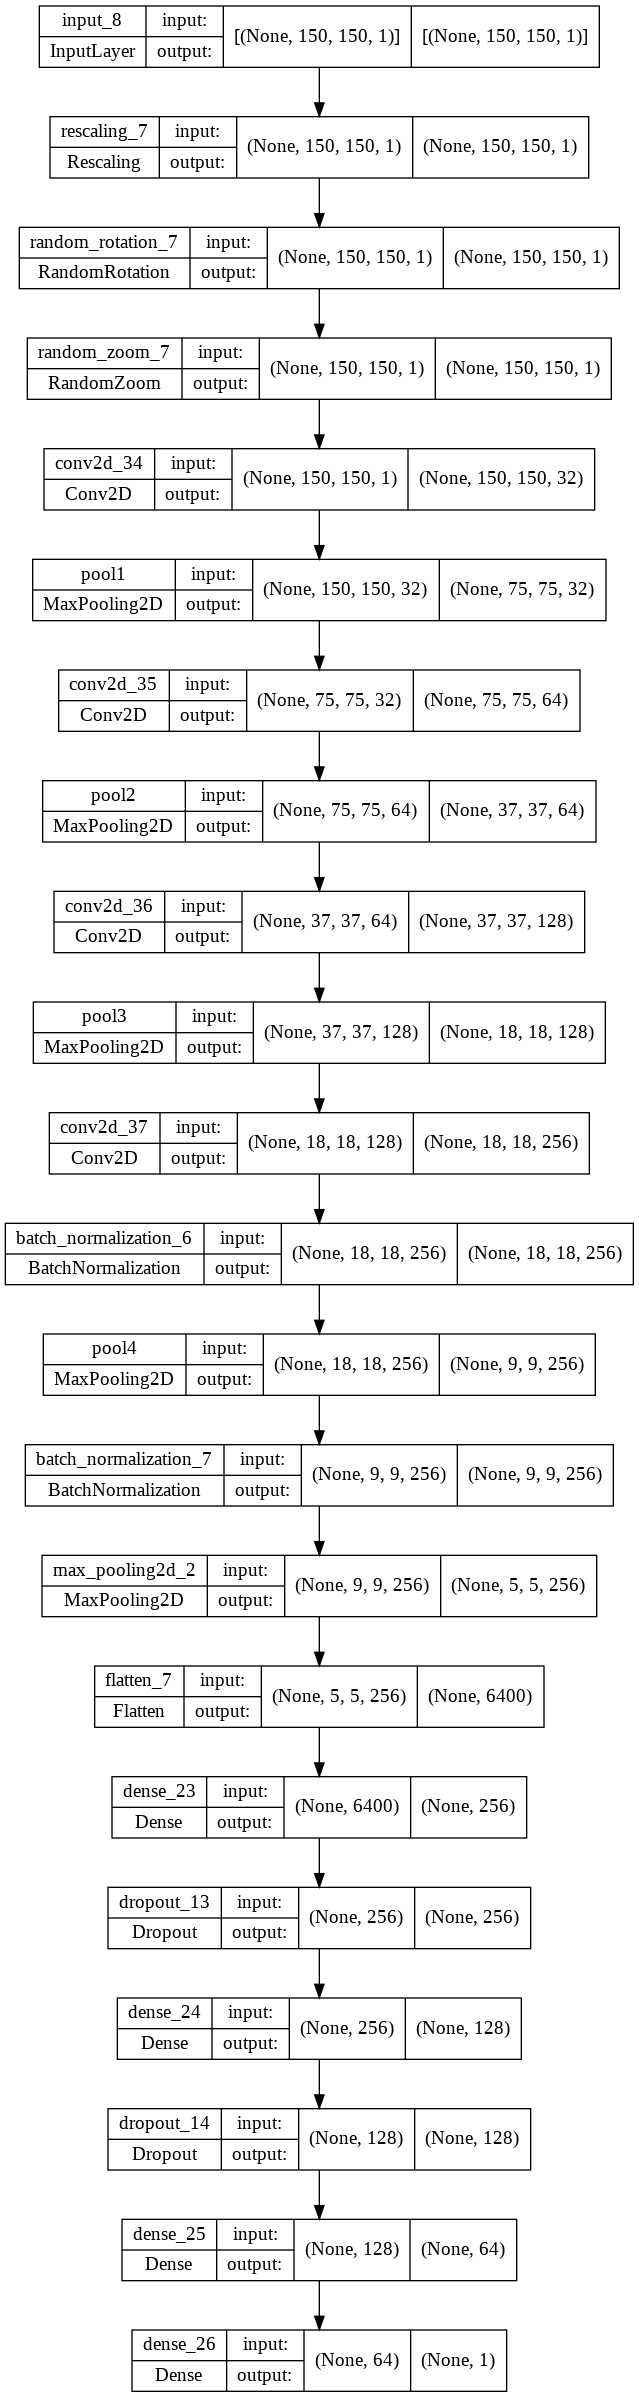

In [44]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.6)(x)
    x = layers.RandomZoom(0.2)(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool2')(x)    

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)

    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)      
    x = Dense(64, activation='relu')(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model9 = make_model(input_shape=(image_size) + (1,), num_classes=2)
keras.utils.plot_model(model9, show_shapes=True)


In [45]:
model9.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 rescaling_7 (Rescaling)     (None, 150, 150, 1)       0         
                                                                 
 random_rotation_7 (RandomRo  (None, 150, 150, 1)      0         
 tation)                                                         
                                                                 
 random_zoom_7 (RandomZoom)  (None, 150, 150, 1)       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 75, 75, 32)        0         
                                                           

In [46]:
early_stop = EarlyStopping(monitor= "val_loss", mode="min", patience = 10, restore_best_weights=True)
mod_checkpt = ModelCheckpoint(filepath ="/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/my_model9.h5",monitor= "val_loss", save_best_only=True )
lr_rate = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=.000000001)
log_dir = "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/logs fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stop, mod_checkpt, lr_rate, tensorboard_callback]

In [47]:
model9.compile(optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])

result_9 = model9.fit(train_ds, epochs=500, batch_size=50, validation_data=val_ds, shuffle=True, callbacks=callbacks)

Epoch 1/500
101/101 [==============================] - 47s 450ms/step - loss: 0.5483 - accuracy: 0.7499 - recall_7: 0.8596 - val_loss: 0.4638 - val_accuracy: 0.7286 - val_recall_7: 1.0000 - lr: 0.0010
Epoch 2/500
101/101 [==============================] - 44s 427ms/step - loss: 0.3104 - accuracy: 0.8696 - recall_7: 0.9156 - val_loss: 0.4032 - val_accuracy: 0.7476 - val_recall_7: 1.0000 - lr: 0.0010
Epoch 3/500
101/101 [==============================] - 45s 438ms/step - loss: 0.2584 - accuracy: 0.8935 - recall_7: 0.9266 - val_loss: 0.7837 - val_accuracy: 0.7238 - val_recall_7: 1.0000 - lr: 0.0010
Epoch 4/500
101/101 [==============================] - 45s 443ms/step - loss: 0.2529 - accuracy: 0.8959 - recall_7: 0.9271 - val_loss: 0.7243 - val_accuracy: 0.7286 - val_recall_7: 1.0000 - lr: 0.0010
Epoch 5/500
101/101 [==============================] - 46s 448ms/step - loss: 0.2420 - accuracy: 0.9016 - recall_7: 0.9236 - val_loss: 0.2767 - val_accuracy: 0.8857 - val_recall_7: 0.9737 - lr: 0.

In [ ]:
model9_eval = model_eval(model9)

In [82]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    # x = layers.Rescaling(1./255)(inputs)
    # x = layers.RandomRotation(0.6)(x)
    # x = layers.RandomZoom(0.2)(inputs)

    x = Conv2D(32, 3, activation='relu', padding='same')(inputs)    
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool2')(x)    

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)

    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    # x = layers.BatchNormalization()(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    # x = layers.BatchNormalization()(x)
    # x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)
    # x = Dense(128, activation='relu')(x)
    # x = Dense(64, activation='relu')(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model10 = make_model(input_shape=(image_size) + (1,), num_classes=2)

In [83]:
visualizer(model10)

ValueError: ignored

In [ ]:
from keras_visualizer import visualizer  
visualizer(model3)

In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/chest_xray/test/NORMAL/NORMAL2-IM-0359-0001.jpeg",grayscale=True, target_size=(128,128,1))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model1.predict(img_array)
score = predictions[0]
print(    "This image is %.2f percent Normal and %.2f percent Pneumonia ."
    % (100 * (1 - score), 100 * score))

In [ ]:
for images, labels in test_ds.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()